<a href="https://colab.research.google.com/github/amanichopra/understanding-deep-learning-textbook-exercises/blob/main/11_1_Shattered_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 11.1: Shattered gradients**

This notebook investigates the phenomenon of shattered gradients as discussed in section 11.1.1.  It replicates some of the experiments in [Balduzzi et al. (2017)](https://arxiv.org/abs/1702.08591).

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

First let's define a neural network. We'll initialize both the weights and biases randomly with Glorot initialization (He initialization without the factor of two)

In [3]:
# K is width, D is number of hidden units in each layer
def init_params(K, D):
  # Set seed so we always get the same random numbers
  np.random.seed(1)

  # Input layer
  D_i = 1
  # Output layer
  D_o = 1

  # Glorot initialization
  sigma_sq_omega = 1.0/D

  # Make empty lists
  all_weights = [None] * (K+1)
  all_biases = [None] * (K+1)

  # Create parameters for input and output layers
  all_weights[0] = np.random.normal(size=(D, D_i))*np.sqrt(sigma_sq_omega)
  all_weights[-1] = np.random.normal(size=(D_o, D)) * np.sqrt(sigma_sq_omega)
  all_biases[0] = np.random.normal(size=(D,1))* np.sqrt(sigma_sq_omega)
  all_biases[-1]= np.random.normal(size=(D_o,1))* np.sqrt(sigma_sq_omega)

  # Create intermediate layers
  for layer in range(1,K):
    all_weights[layer] = np.random.normal(size=(D,D))*np.sqrt(sigma_sq_omega)
    all_biases[layer] = np.random.normal(size=(D,1))* np.sqrt(sigma_sq_omega)

  return all_weights, all_biases

The next two functions define the forward pass of the algorithm

In [4]:
# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

def forward_pass(net_input, all_weights, all_biases):

  # Retrieve number of layers
  K = len(all_weights) -1

  # We'll store the pre-activations at each layer in a list "all_f"
  # and the activations in a second list[all_h].
  all_f = [None] * (K+1)
  all_h = [None] * (K+1)

  #For convenience, we'll set
  # all_h[0] to be the input, and all_f[K] will be the output
  all_h[0] = net_input

  # Run through the layers, calculating all_f[0...K-1] and all_h[1...K]
  for layer in range(K):
      # Update preactivations and activations at this layer according to eqn 7.5
      all_f[layer] = all_biases[layer] + np.matmul(all_weights[layer], all_h[layer])
      all_h[layer+1] = ReLU(all_f[layer])

  # Compute the output from the last hidden layer
  all_f[K] = all_biases[K] + np.matmul(all_weights[K], all_h[K])

  # Retrieve the output
  net_output = all_f[K]

  return net_output, all_f, all_h

The next two functions compute the gradient of the output with respect to the input using the back propagation algorithm.

In [5]:
# We'll need the indicator function
def indicator_function(x):
  x_in = np.array(x)
  x_in[x_in>=0] = 1
  x_in[x_in<0] = 0
  return x_in

# Main backward pass routine
def calc_input_output_gradient(x_in, all_weights, all_biases):

  # Run the forward pass
  y, all_f, all_h = forward_pass(x_in, all_weights, all_biases)

  # We'll store the derivatives dl_dweights and dl_dbiases in lists as well
  all_dl_dweights = [None] * (K+1)
  all_dl_dbiases = [None] * (K+1)
  # And we'll store the derivatives of the loss with respect to the activation and preactivations in lists
  all_dl_df = [None] * (K+1)
  all_dl_dh = [None] * (K+1)
  # Again for convenience we'll stick with the convention that all_h[0] is the net input and all_f[k] in the net output

  # Compute derivatives of net output with respect to loss
  all_dl_df[K] = np.ones_like(all_f[K])

  # Now work backwards through the network
  for layer in range(K,-1,-1):
    all_dl_dbiases[layer] = np.array(all_dl_df[layer])
    all_dl_dweights[layer] = np.matmul(all_dl_df[layer], all_h[layer].transpose())

    all_dl_dh[layer] = np.matmul(all_weights[layer].transpose(), all_dl_df[layer])

    if layer > 0:
      all_dl_df[layer-1] = indicator_function(all_f[layer-1]) * all_dl_dh[layer]


  return all_dl_dh[0],y

Double check we have the gradient correct using finite differences

In [6]:
D = 200; K = 3
# Initialize parameters
all_weights, all_biases = init_params(K,D)

x = np.ones((1,1))
dydx,y = calc_input_output_gradient(x, all_weights, all_biases)

# Offset for finite gradients
delta = 0.00000001
x1 = x
y1,*_ = forward_pass(x1, all_weights, all_biases)
x2 = x+delta
y2,*_ = forward_pass(x2, all_weights, all_biases)
# Finite difference calculation
dydx_fd = (y2-y1)/delta

print("Gradient calculation=%f, Finite difference gradient=%f"%(dydx.squeeze(),dydx_fd.squeeze()))


Gradient calculation=0.013250, Finite difference gradient=0.013250


Helper function that computes the derivatives for a 1D array of input values and plots them.

In [37]:
def plot_derivatives(K, D, plot_network=False):

  # Initialize parameters
  all_weights, all_biases = init_params(K,D)

  x_in = np.arange(-2,2, 4.0/256.0)
  x_in = np.resize(x_in, (1,len(x_in)))
  dydx,y = calc_input_output_gradient(x_in, all_weights, all_biases)

  fig, ax = plt.subplots()

  # First plot: gradient
  ax.plot(np.squeeze(x_in), np.squeeze(dydx), 'b-', label=r'Gradient $dy/dx$')
  ax.set_xlim(-2, 2)
  ax.set_xlabel(r'Input, $x$')
  ax.set_ylabel(r'Value')
  ax.set_title('No layers = %d, No hidden units = %d' % (K, D))

  # Optional second plot: network activations
  if plot_network:
      ax.plot(x_in.T, y.T, 'r--', label='Network Activations')

  # Add legend if either one has labels
  ax.legend()
  plt.show()

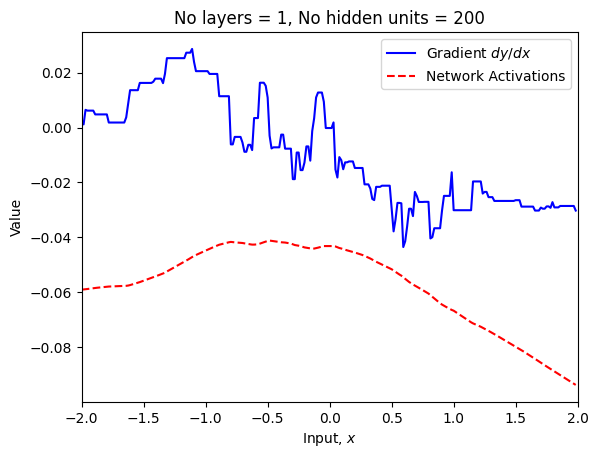

In [43]:
# Build a model with one hidden layer and 200 neurons and plot derivatives
D = 200; K = 1
plot_derivatives(K,D, plot_network=True)

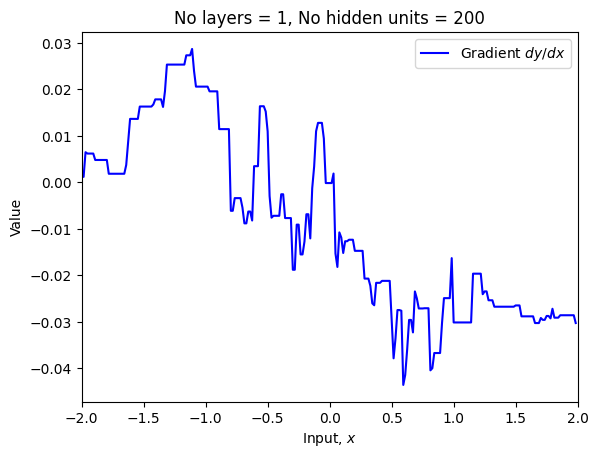

In [44]:
plot_derivatives(K,D)

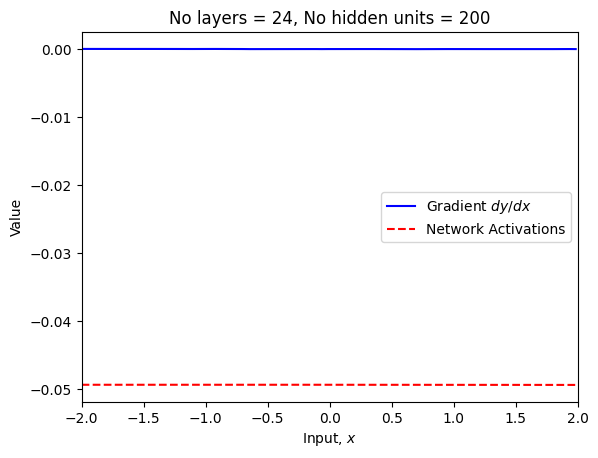

In [45]:
# TODO -- Add code to plot the derivatives for models with 24 and 50 hidden layers
# with 200 neurons per layer
# Build a model with one hidden layer and 200 neurons and plot derivatives
D = 200; K = 24
plot_derivatives(K,D, plot_network=True)


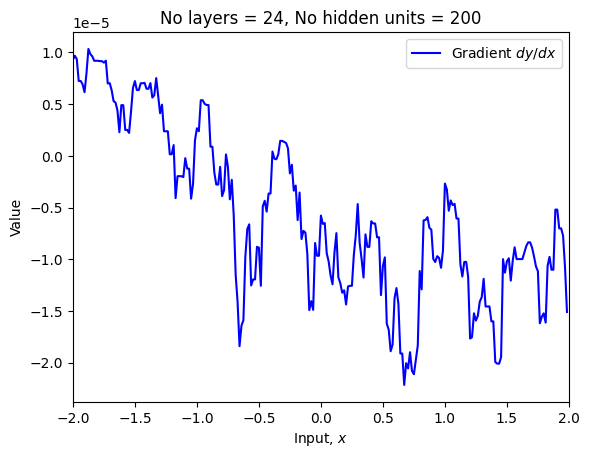

In [46]:
plot_derivatives(K,D)

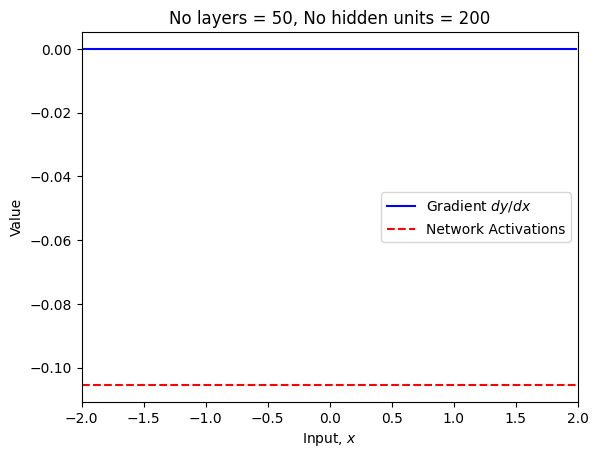

In [47]:
# TODO -- Add code to plot the derivatives for models with 24 and 50 hidden layers
# with 200 neurons per layer
# Build a model with one hidden layer and 200 neurons and plot derivatives
D = 200; K = 50
plot_derivatives(K,D, plot_network=True)


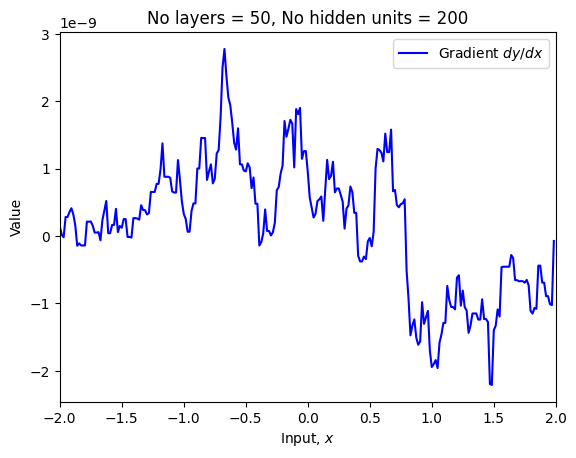

In [48]:
plot_derivatives(K,D)

Let's look at the autocorrelation function now

In [49]:
def autocorr(dydx):
    # TODO -- compute the autocorrelation function
    # Use the numpy function "correlate" with the mode set to "same"
    # Replace this line:
    ac = np.correlate(dydx, dydx, mode='same')

    return ac

Helper function to plot the autocorrelation function and normalize so correlation is one with offset of zero

In [50]:
def plot_autocorr(K, D):

  # Initialize parameters
  all_weights, all_biases = init_params(K,D)

  x_in = np.arange(-2.0,2.0, 4.0/256)
  x_in = np.resize(x_in, (1,len(x_in)))
  dydx,y = calc_input_output_gradient(x_in, all_weights, all_biases)
  ac = autocorr(np.squeeze(dydx))
  ac = ac / ac[128]

  y = ac[128:]
  x = np.squeeze(x_in)[128:]
  fig,ax = plt.subplots()
  ax.plot(x,y, 'b-')
  ax.set_xlim([0,2])
  ax.set_xlabel('Distance')
  ax.set_ylabel('Autocorrelation')
  ax.set_title('No layers = %d'%(K))
  plt.show()


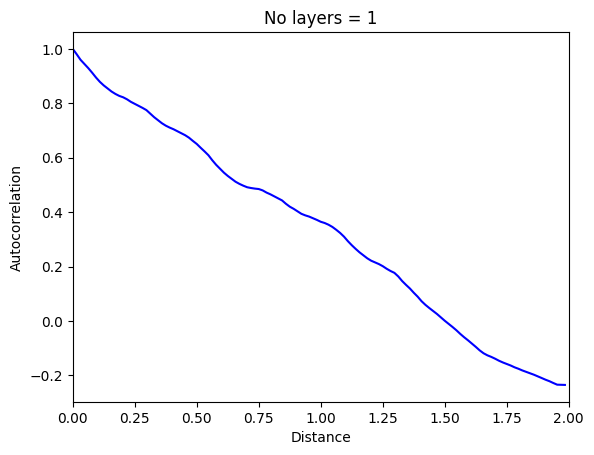

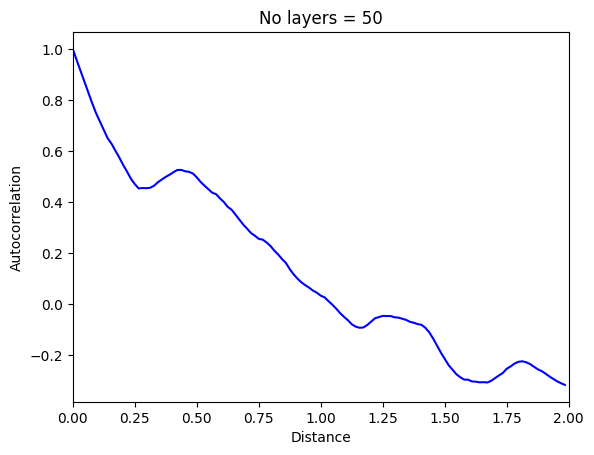

In [51]:
# Plot the autocorrelation functions
D = 200; K =1
plot_autocorr(K,D)
D = 200; K =50
plot_autocorr(K,D)


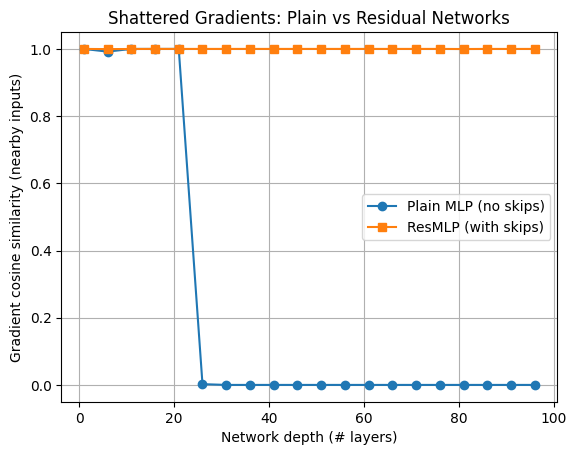

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# ----- Plain MLP -----
class PlainMLP(nn.Module):
    def __init__(self, depth=10, width=100):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# ----- Residual MLP -----
class ResidualBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fc = nn.Linear(width, width)
        self.relu = nn.ReLU()

    def forward(self, x):
        return x + self.relu(self.fc(x))  # skip connection


class ResMLP(nn.Module):
    def __init__(self, depth=10, width=100):
        super().__init__()
        self.layers = nn.ModuleList([ResidualBlock(width) for _ in range(depth)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# ----- Gradient correlation experiment -----
def gradient_cosine_similarity(model_class, depth, width=100):
    torch.manual_seed(0)  # reproducibility
    model = model_class(depth, width)

    # Input + nearby perturbed input
    x1 = torch.randn(1, width, requires_grad=True)
    x2 = x1 + 1e-3 * torch.randn_like(x1)

    # Scalar outputs
    y1 = model(x1).sum()
    y2 = model(x2).sum()

    # Gradients wrt inputs
    g1 = torch.autograd.grad(y1, x1, retain_graph=True)[0]
    g2 = torch.autograd.grad(y2, x2)[0]
    sim = F.cosine_similarity(g1.flatten(), g2.flatten(), dim=0).item()

    # Cosine similarity
    return sim


# ----- Run experiment -----
depths = list(range(1, 101, 5))
plain_sims = [gradient_cosine_similarity(PlainMLP, d) for d in depths]
res_sims   = [gradient_cosine_similarity(ResMLP, d) for d in depths]

# Plot
plt.plot(depths, plain_sims, marker="o", label="Plain MLP (no skips)")
plt.plot(depths, res_sims, marker="s", label="ResMLP (with skips)")
plt.xlabel("Network depth (# layers)")
plt.ylabel("Gradient cosine similarity (nearby inputs)")
plt.title("Shattered Gradients: Plain vs Residual Networks")
plt.legend()
plt.grid(True)
plt.show()


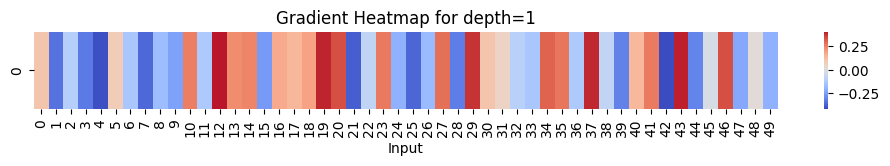

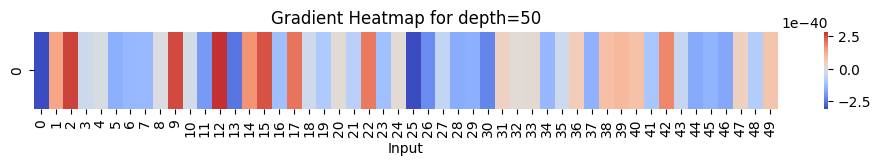

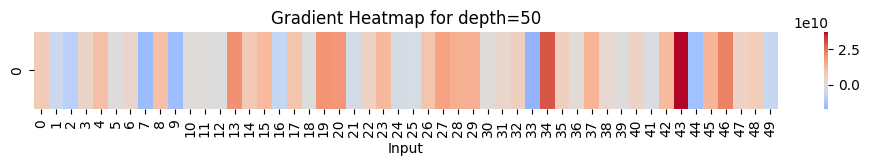

In [70]:
import seaborn as sns

# ----- Gradient heatmap function -----
def plot_gradient_heatmap(model, depth, width):
    torch.manual_seed(0)
    x = torch.randn(1, width, requires_grad=True)
    y = model(x).sum()
    g = torch.autograd.grad(y, x)[0].detach().numpy().flatten()

    plt.figure(figsize=(12,1))
    sns.heatmap([g], cmap="coolwarm", center=0)
    plt.title(f"Gradient Heatmap for depth={depth//2}")
    plt.xlabel("Input")
    plt.show()

# ----- Shallow network -----
shallow_model = PlainMLP(depth=2, width=50)
plot_gradient_heatmap(shallow_model, 2, 50)

# ----- Deep network -----
deep_model = PlainMLP(depth=100, width=50)
plot_gradient_heatmap(deep_model, 100, 50)

# ----- Residual network -----
resnet = ResMLP(depth=100, width=50)
plot_gradient_heatmap(resnet, 100, 50)